In [2]:
import sys
import healpy as hp
from astropy import units
import matplotlib.pyplot as plt
import numpy as np


sys.path.append('/Users/rebeccaceppas/Desktop/CHORD/spatial_matched_filter')

import maps
import mf_2d as m2
import mf_1d as m1

%load_ext autoreload
%autoreload 2

In [126]:
def normalize(array):
    return array/np.max(array)

# Define resolution of map

In [249]:
nside = 128
resolution = (hp.nside2resol(nside) * units.rad).to(units.deg).value

# Initialize an input map and create a 2d map

Text(0, 0.5, 'dec')

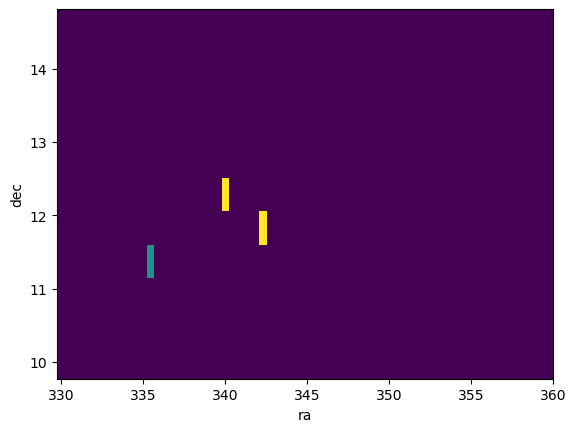

In [345]:
seed = 747

input_map = maps.InputMap(ra_max=360, ra_min=330, 
                          dec_max=15, dec_min=10,
                          nsources=3, 
                          resolution=resolution,
                          seed=seed)

map2d = input_map.get_2d_map(brightness=[1,1,0.5])

plt.pcolor(input_map.ra, input_map.dec, map2d)
plt.xlabel('ra')
plt.ylabel('dec')

# Add instrumental effects

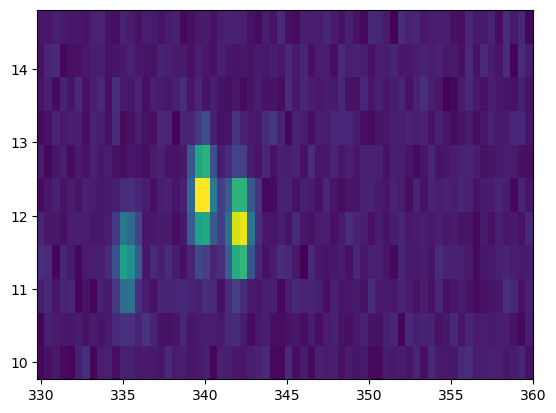

In [346]:
beam2d = input_map.get_2d_beam(maps.gaussian_beam, 1)

map_obs = input_map.observe(map2d, beam2d, add_noise=True, noise_std=3e-2)

plt.pcolor(input_map.ra, input_map.dec, map_obs)
plt.show()

# Turn into 1d map

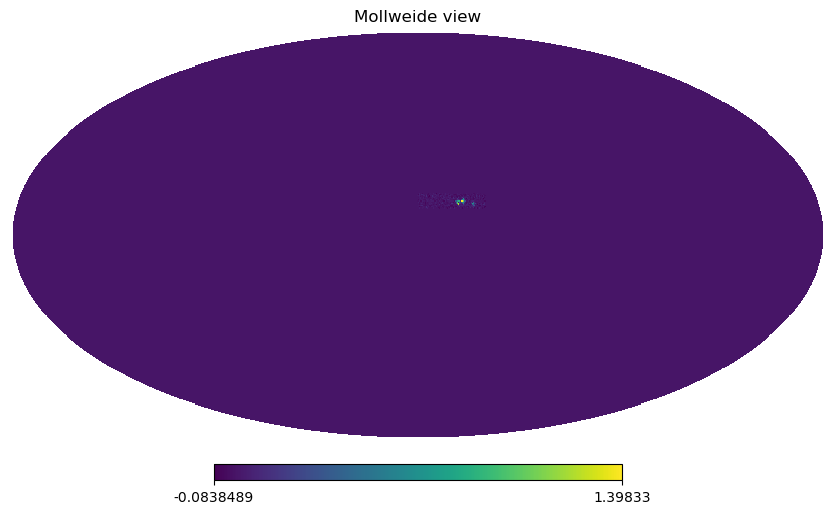

In [347]:
map1d_obs = input_map.get_1d_map(nside=nside, map_2d=map_obs)
map1d = input_map.get_1d_map(nside=nside, map_2d=map2d)
hp.mollview(map1d_obs)

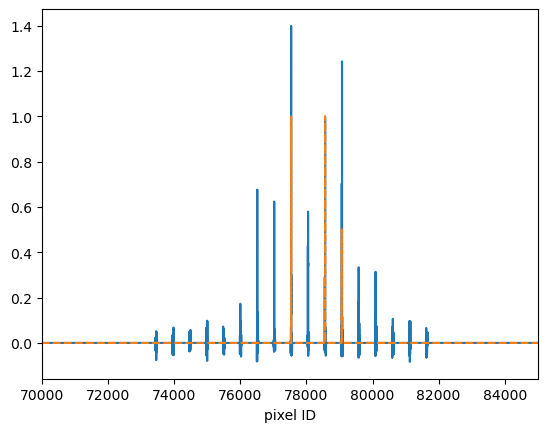

In [348]:
xlim = (70000, 85000)
plt.plot(map1d_obs)
plt.plot(map1d, '--')
plt.xlim(xlim)
plt.xlabel('pixel ID')
plt.show()

In [349]:
beam1d = input_map.get_1d_map(nside, beam2d)

# 2D matched filter

In [378]:
denom = np.fft.fft2(np.sqrt(beam2d * beam2d))

mf2d_denom = np.fft.fftshift(
    np.fft.ifftshift(
    np.fft.ifft2(
        np.fft.fftshift(
            np.fft.fft2(map_obs) * np.fft.fft2(beam2d) / denom
    ))))


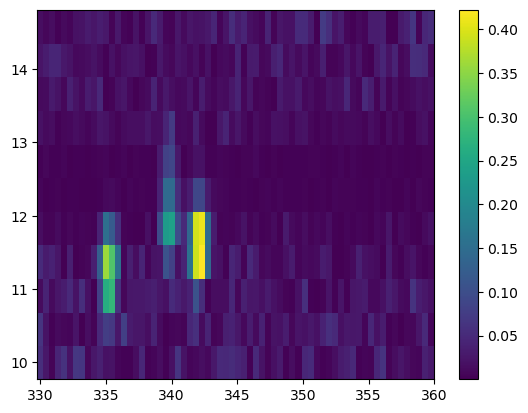

In [379]:
plt.pcolor(input_map.ra, input_map.dec, np.abs((mf2d_denom.real)))
plt.colorbar()
plt.show()

# 1D matched filter

In [380]:
denom = np.fft.fft(np.sqrt(beam1d * beam1d))

mf1d_denom = np.fft.fftshift(
    np.fft.ifftshift(
    np.fft.ifft(
        np.fft.fftshift(
            np.fft.fft(map1d_obs) * np.fft.fft(beam1d) / denom
    ))))

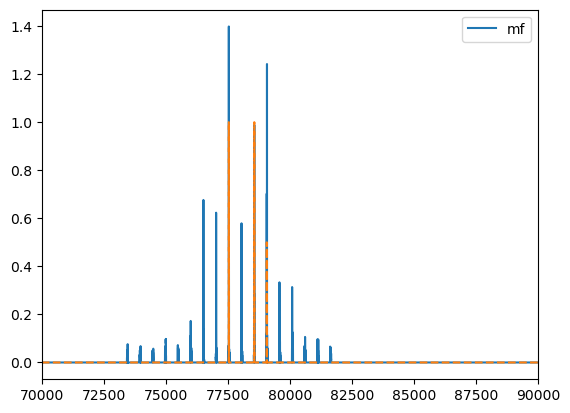

In [382]:
plt.plot(np.abs(mf1d_denom), label='mf')
plt.plot(map1d, '--')
plt.xlim(70000, 90000)
plt.legend()
plt.show()

# 1d -> 2d conversion test

In [383]:
test_1d = input_map.get_1d_map(nside, np.abs(map_obs))
test_2d = input_map.get_2d_from_1d(test_1d)

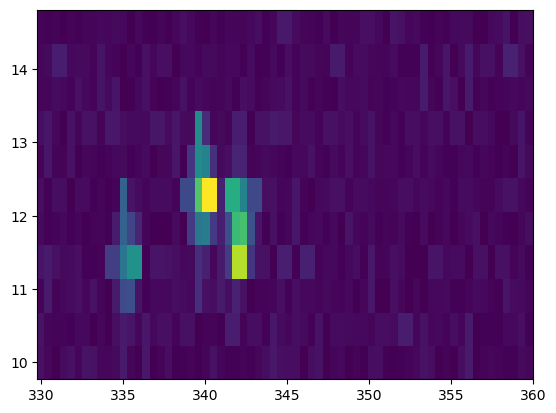

In [384]:
plt.pcolor(input_map.ra, input_map.dec, test_2d)

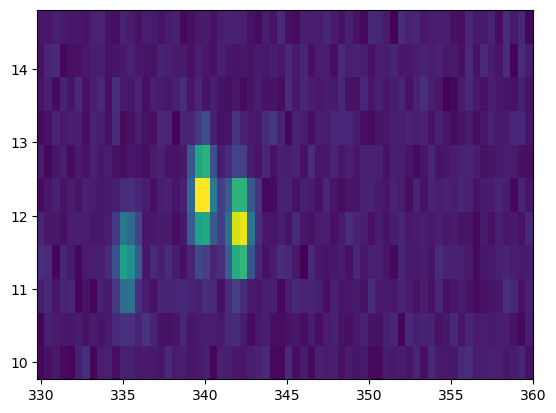

In [385]:
plt.pcolor(input_map.ra, input_map.dec, map_obs)

# Comparing 2d and 1d matched filters

In [386]:
mf_1d_to_2d = input_map.get_2d_from_1d(mf1d_denom.real)

to_1d = input_map.get_1d_map(nside, mf2d_denom)
mf_2d_to_2d = input_map.get_2d_from_1d(to_1d)

/Users/rebeccaceppas/Desktop/CHORD/spatial_matched_filter/maps.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  map_1d[pix] += map_2d[j, i]


Text(0.5, 1.0, '1d matched filter')

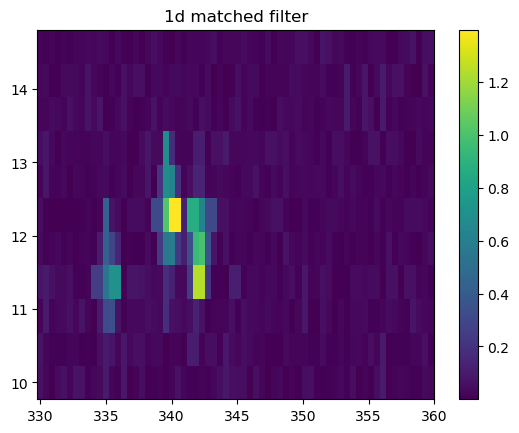

In [387]:
plt.pcolor(input_map.ra, input_map.dec, np.abs(mf_1d_to_2d))
plt.colorbar()
plt.title('1d matched filter')

Text(0.5, 1.0, '2d matched filter')

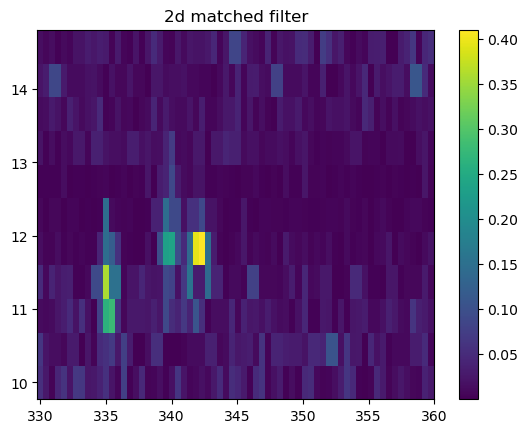

In [388]:
plt.pcolor(input_map.ra, input_map.dec, np.abs(mf_2d_to_2d))
plt.colorbar()
plt.title('2d matched filter')

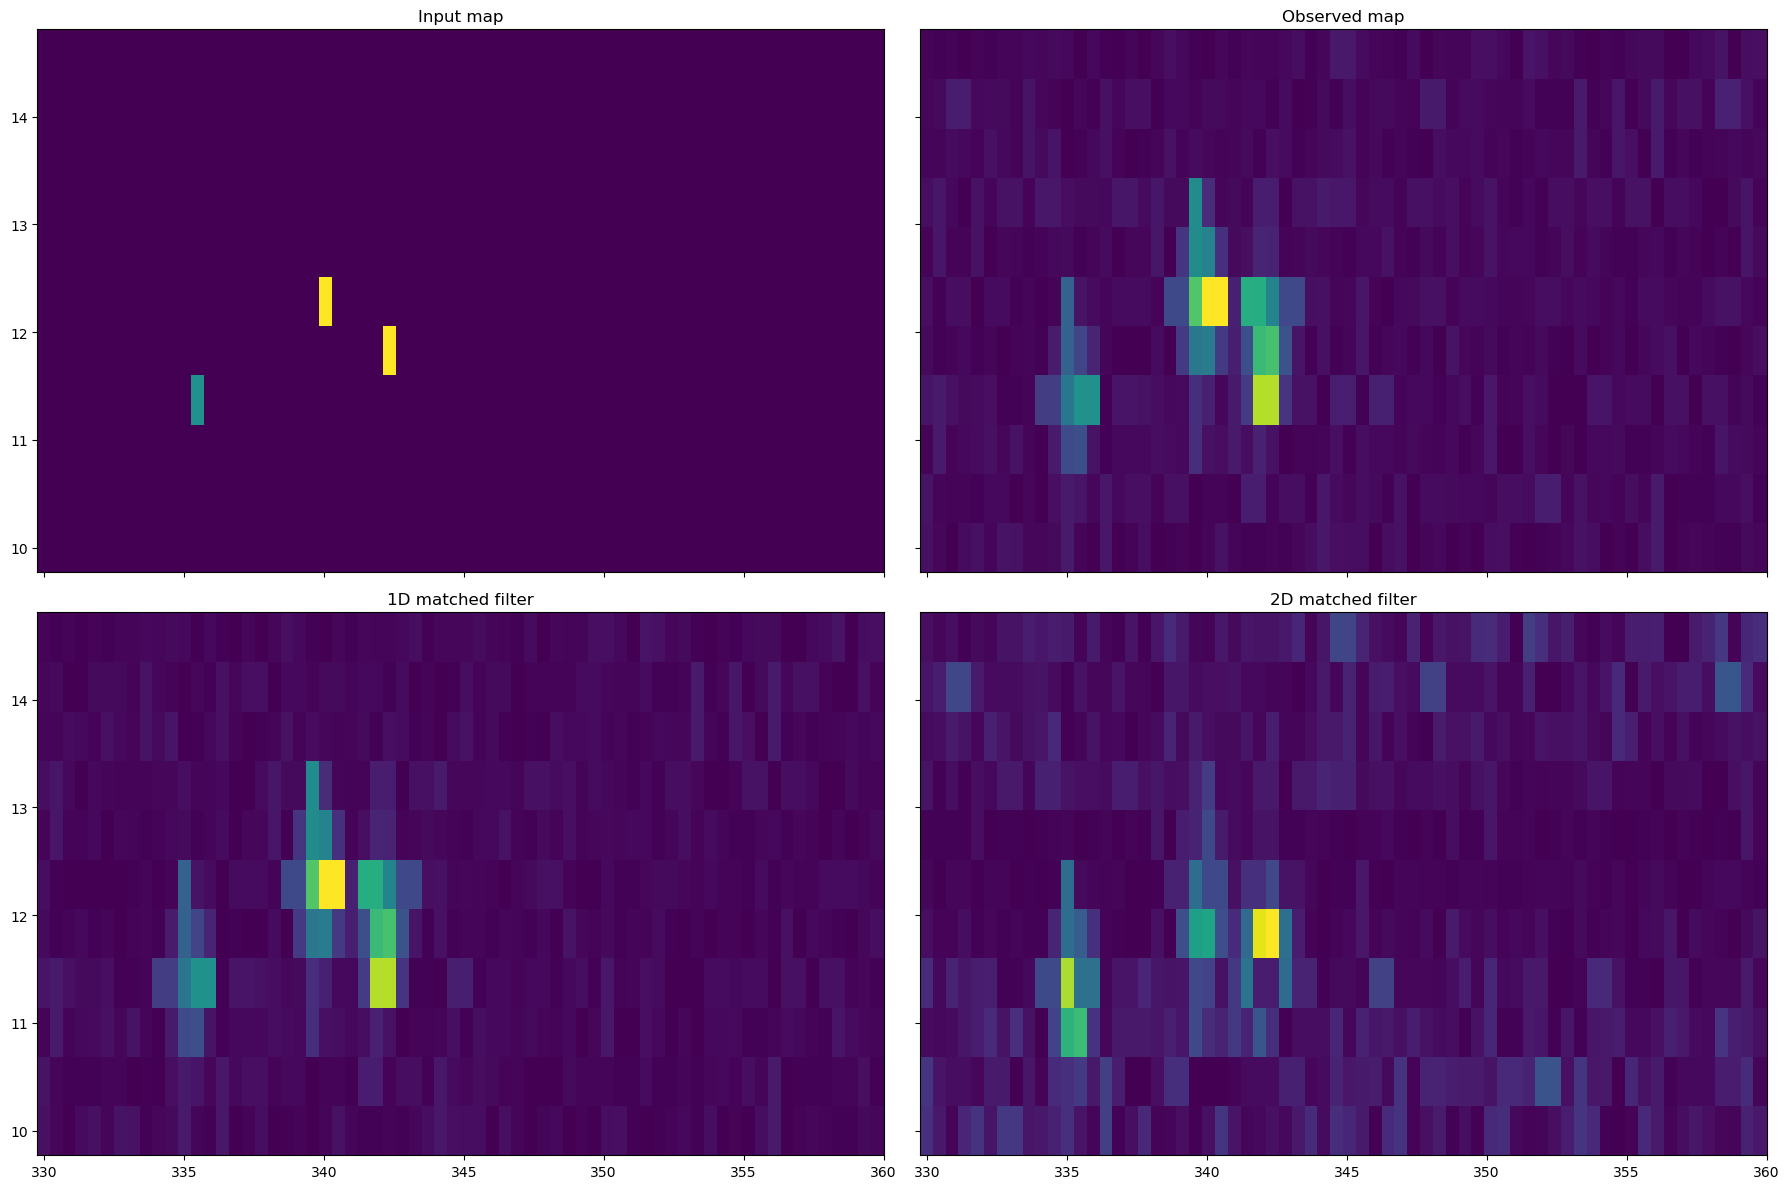

In [389]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(18,12))

ax[0,0].pcolor(input_map.ra, input_map.dec, map2d)
ax[0,0].set_title('Input map')

ax[0,1].pcolor(input_map.ra, input_map.dec, test_2d)
ax[0,1].set_title('Observed map')

ax[1,0].pcolor(input_map.ra, input_map.dec, np.abs(mf_1d_to_2d))
ax[1,0].set_title('1D matched filter')

ax[1,1].pcolor(input_map.ra, input_map.dec, np.abs(mf_2d_to_2d))
ax[1,1].set_title('2D matched filter')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'input map - 1d mf')

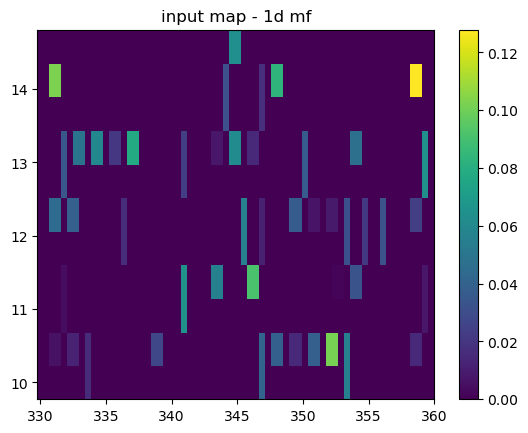

In [392]:
plt.pcolor(input_map.ra, input_map.dec, test_2d - np.abs(mf_1d_to_2d))
plt.colorbar()
plt.title('input map - 1d mf')

# Detection

In [396]:
from photutils.detection import find_peaks

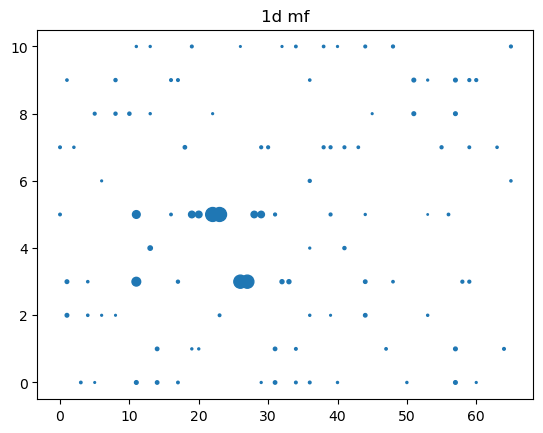

In [413]:
peaks_1d = find_peaks(mf_1d_to_2d/np.max(mf_1d_to_2d), 0.01)
plt.scatter(peaks_1d['x_peak'], peaks_1d['y_peak'], s=peaks_1d['peak_value']*100)
plt.title('1d mf')
plt.show()

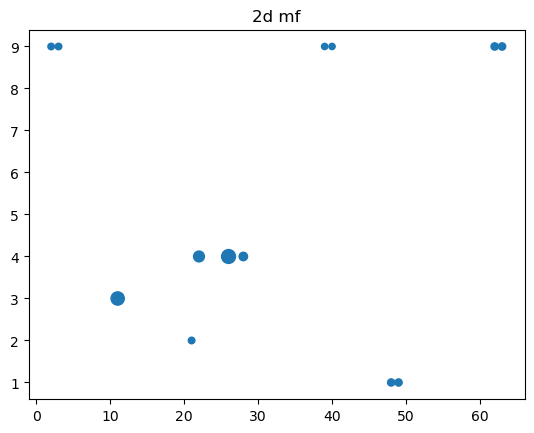

In [417]:
peaks_2d = find_peaks(mf_2d_to_2d/np.max(mf_2d_to_2d), 0.2)
plt.scatter(peaks_2d['x_peak'], peaks_2d['y_peak'], s=peaks_2d['peak_value']*100)
plt.title('2d mf')
plt.show()